In [1]:
from pathlib import Path
from planet4 import clustering, io, markings

In [2]:
# At the beginning of the notebook
import logging
logger = logging.getLogger()
assert len(logger.handlers) == 1
logger.addHandler(logging.StreamHandler())
handler = logger.handlers[1]
handler.setLevel(logging.DEBUG)

In [3]:
obsid = 'ESP_011394_0935'
#obsid = 'ESP_012821_0865'

In [17]:
path = io.p4data() / ('overlap_issue_GH45/hirise_level/' + obsid)
path.mkdir(exist_ok=True, parents=True)
cm = clustering.ClusteringManager(fnotched_dir=path,
                                 include_angle=True, include_distance=False, 
                                 include_radius=False)

In [18]:
cm.cluster_image_name(obsid)

Clustering data for ESP_011394_0935
ClusterManager: cluster_data()
Running DBSCAN
Estimated number of clusters: 482
Reduced data to 482 fan(e)s.
Running DBSCAN
Estimated number of clusters: 929
Reduced data to 929 blotch(e)s.
CM: do_the_fnotch
CM: do_the_fnotch: max_hits: 4
CM: do_the_fnotch: Found 458 fnotches.
Clustering and fnotching completed.
CM: Writing output files.
CM: Output dir: /Users/klay6683/Dropbox/data/planet4/overlap_issue_GH45/hirise_level/ESP_011394_0935
Executing apply_fnotch_cut
Executing get_newfans_newblotches
Finished apply_fnotch_cut.


In [19]:
cm.pm.fnotchfile

PosixPath('/Users/klay6683/Dropbox/data/planet4/overlap_issue_GH45/hirise_level/ESP_011394_0935/ESP_011394_0935_fnotches.csv')

In [20]:
db = io.DBManager()

In [21]:
data = db.get_image_name_markings(obsid)

In [22]:
image_ids = data.image_id.unique()

In [23]:
def do_in_parallel(image_id):
    from pathlib import Path
    from planet4 import clustering, io
    path = io.p4data() / ('overlap_issue_GH45/p4_level_p4_coords/' + obsid)
    path.mkdir(exist_ok=True, parents=True)
    cm = clustering.ClusteringManager(fnotched_dir=path, scope='planet4',
                                 include_angle=True, include_distance=False, 
                                 include_radius=False, eps=10, min_distance=10)
    try:
        cm.cluster_image_id(image_id)
    except:
        return image_id, False
    else:
        return image_id, True

In [24]:
from nbtools import ListProgressBar, display_multi_progress

In [25]:
from ipyparallel import Client
c = Client()

In [26]:
dview = c.direct_view()

In [27]:
dview.push({'obsid':obsid})

<AsyncResult: _push>

In [28]:
lbview = c.load_balanced_view()

In [29]:
results = lbview.map_async(do_in_parallel, image_ids)

In [30]:
display_multi_progress(results, image_ids)

In [27]:
class Comparer(object):
    markings = ['fans','blotches','fnotches']
    root = io.p4data() / 'overlap_issue_GH45'
    
    def __init__(self, path, fnotched=True):
        if fnotched is True:
            self.path = self.root / path
        else:
            self.path = self.root / path / 'just_clustering'
        
    @property
    def blotches_iter(self):
        return self.path.glob("*_blotches.csv")
    
    @property
    def fans_iter(self):
        return self.path.glob("*_fans.csv")

    @property
    def fnotches_iter(self):
        return self.path.glob('*_fnotches.csv')
            
    def get_length(self, theiter):
        return sum([len(pd.read_csv(str(f))) for f in theiter])

    @property
    def blotches_lengths(self):
        return self.get_length(self.blotches_iter)
    
    @property
    def fans_lengths(self):
        return self.get_length(self.fans_iter)
    
    @property
    def fnotches_lengths(self):
        return self.get_length(self.fnotches_iter)

    def get_total_survivors(self):
        blotches = self.blotches_lengths
        fans = self.fans_lengths
        fnotches = self.fnotches_lengths
        total = blotches + fans + fnotches
        print("Blotches: {}\nFan: {}\nFnotches: {}".format(blotches, fans, fnotches))
        print("Total: {}".format(total))
        
    def read_dataframes(self, marking, as_df=True):
        res = [pd.read_csv(str(p)) for p in self.path.glob('*_{}.csv'.format(marking))]
        return pd.concat(res) if as_df else res
    
    def read_combined_df(self):
        combine_all = []
        for marking in self.markings:
            to_combine = read_dataframes(marking)
            combine_all.append(to_combine)
        all_combined = pd.concat(combine_all)
        return all_combined


class HiRISEComparer(Comparer):
    root = io.p4data() / 'overlap_issue_GH45/hirise_level/'

    
class P4Comparer(Comparer):
    root = io.p4data() / 'overlap_issue_GH45/p4_level_p4_coords'

In [5]:
hicomp = HiRISEComparer(obsid)
hicomp.get_total_survivors()

Blotches: 585
Fan: 186
Fnotches: 458
Total: 1229


In [6]:
HiRISEComparer(obsid, fnotched=False).get_total_survivors()

Blotches: 929
Fan: 482
Fnotches: 0
Total: 1411


In [11]:
#def scatter_plot_obsid_data(path):
df = pd.read_hdf(str(next(path.glob("*blotch*.hdf"))))
   

In [12]:
%matplotlib nbagg

In [22]:
P4Comparer(obsid).get_total_survivors()

Blotches: 928
Fan: 364
Fnotches: 144
Total: 1436


In [23]:
P4Comparer(obsid, fnotched=False).get_total_survivors()

Blotches: 1066
Fan: 507
Fnotches: 0
Total: 1573


In [28]:
blotches = P4Comparer(obsid).read_dataframes('blotches')

In [29]:
blotches.head()

,x,y,image_x,image_y,angle,radius_1,radius_2,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y,image_id
0,197.200000,284.600000,197.200000,34260.600000,6.752352,16.882665,14.161999,213.965561,292.233381,180.434439,276.966619,195.534858,298.663766,198.865142,270.536234,APF0000dae
1,250.500000,259.250000,250.500000,34235.250000,25.126677,11.191206,10.268404,260.632195,259.182138,240.367805,259.317862,246.139820,268.546717,254.860180,249.953283,APF0000dae
2,338.250000,181.750000,338.250000,34157.750000,12.258466,14.492125,12.119094,352.411701,177.357982,324.088299,186.142018,335.676849,193.592776,340.823151,169.907224,APF0000dae
3,571.250000,208.750000,571.250000,34184.750000,20.901771,14.870533,12.402900,585.141955,221.930333,557.358045,195.569667,566.825056,220.336708,575.674944,197.163292,APF0000dae
4,498.833333,137.333333,498.833333,34113.333333,4.902402,13.215628,11.578387,512.000614,124.355563,485.666052,150.311104,497.843860,148.869364,499.822807,125.797303,APF0000dae


In [65]:
import seaborn as sns

In [66]:
%matplotlib inline

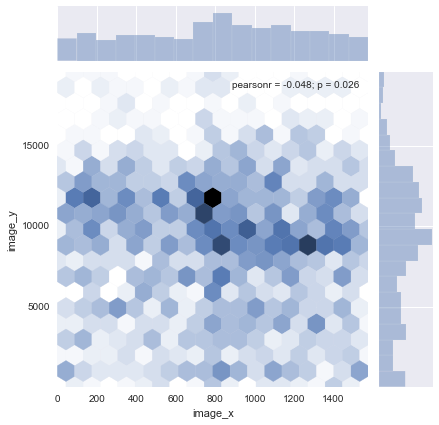

In [68]:
sns.jointplot(x='image_x', y='image_y', kind='hex', data=blotches)

In [25]:
all_combined = read_combined_df(path)

In [30]:
840*648 - (640*448)

257600

In [31]:
_/(840*648)

0.4732510288065844

In [29]:
_/__

0.5267489711934157

In [26]:
all_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254 entries, 0 to 12
Data columns (total 51 columns):
angle              879 non-null float64
arm1_x             139 non-null float64
arm1_y             139 non-null float64
arm2_x             139 non-null float64
arm2_y             139 non-null float64
blotch_angle       375 non-null float64
blotch_image_id    375 non-null object
blotch_image_x     375 non-null float64
blotch_image_y     375 non-null float64
blotch_p1_x        375 non-null float64
blotch_p1_y        375 non-null float64
blotch_p2_x        375 non-null float64
blotch_p2_y        375 non-null float64
blotch_p3_x        375 non-null float64
blotch_p3_y        375 non-null float64
blotch_p4_x        375 non-null float64
blotch_p4_y        375 non-null float64
blotch_radius_1    375 non-null float64
blotch_radius_2    375 non-null float64
blotch_x           375 non-null float64
blotch_y           375 non-null float64
distance           139 non-null float64
fan_angle       

In [13]:
p = io.p4data() / 'overlap_issue_GH45/p4_level_p4_coords/applied_cut_0.5'
get_total_survivors(p)

Blotches: 968
Fan: 286
Fnotches: 0
Total: 1254
